In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler

from tensorflow import keras

# call preprocessing.py寫好的檔案執行資料前處理
from preprocessing import data_prepare
from preprocessing import time_window_strided_sampling

In [7]:
file_path='2017-2019holiday.csv'
index_col='Trip_Start_Timestamp'
verbose = True
TIME_STEPS = 1 # 跑出來比較好的參數
cls_id_selected = 4 # 選擇其中一個cluster做預測
yr_crit = 2019 # # 設定2019前的資料作train data，2019做test data

# Load data
df = pd.read_csv(file_path,index_col=index_col)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Preprocess data
train_x, train_y, test_x, test_y = data_prepare(df, cls_id_selected=cls_id_selected, yr_crit=yr_crit)

# Sliding window time series sampling
X_train, y_train = time_window_strided_sampling(train_x, train_y, time_steps=TIME_STEPS)
X_test, y_test = time_window_strided_sampling(test_x, test_y, time_steps=TIME_STEPS)

INFO: TRAIN/TEST shape BEFORE scaling: (17518, 12) (8759, 12)
INFO: shape of scaled TRAIN_X and TEST_X: (17518, 11) (8759, 11)
INFO: shape of TRAIN_Y and TEST_Y: (17518,) (8759,)


In [20]:
lr = 1.E-2
num_epochs = 30 # set 40 epochs 跑效果比較好
batch_size = 32
lstm_unit_size = 128

in_shape = (X_train.shape[1:3])
# Model construction set 2 layers
layers = [
    keras.layers.Bidirectional(keras.layers.LSTM(unit_forget_bias=True,
                                                 units=lstm_unit_size,
                                                 input_shape=in_shape,
                                                 return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(unit_forget_bias=True,
                                                 units=lstm_unit_size,
                                                 return_sequences=False)),
    keras.layers.Dense(units=32, activation="relu"),
    keras.layers.Dense(units=1),
]

model = keras.Sequential()

for layer in layers:
    model.add(layer)

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=lr))

model.build(X_train.shape[0:3])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (17470, 48, 256)          143360    
_________________________________________________________________
bidirectional_15 (Bidirectio (17470, 256)              394240    
_________________________________________________________________
dense_16 (Dense)             (17470, 32)               8224      
_________________________________________________________________
dense_17 (Dense)             (17470, 1)                33        
Total params: 545,857
Trainable params: 545,857
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    shuffle=True)

Epoch 1/30
546/546 [==============================] - 52s 82ms/step - loss: 2898.0623 - val_loss: 1533.0574
Epoch 2/30
546/546 [==============================] - 44s 80ms/step - loss: 2249.1017 - val_loss: 1528.7343
Epoch 3/30
546/546 [==============================] - 44s 80ms/step - loss: 2073.6736 - val_loss: 1535.5790
Epoch 4/30
546/546 [==============================] - 43s 80ms/step - loss: 1878.1596 - val_loss: 1289.1179
Epoch 5/30
546/546 [==============================] - 44s 80ms/step - loss: 1840.7166 - val_loss: 1567.1471
Epoch 6/30
546/546 [==============================] - 44s 81ms/step - loss: 1860.2898 - val_loss: 1345.4543
Epoch 7/30
546/546 [==============================] - 44s 80ms/step - loss: 1595.6855 - val_loss: 1241.1329
Epoch 8/30
546/546 [==============================] - 44s 81ms/step - loss: 1598.2834 - val_loss: 1261.8198
Epoch 9/30
546/546 [==============================] - 44s 81ms/step - loss: 1540.3089 - val_loss: 1291.6805
Epoch 10/30
546/546 [=======

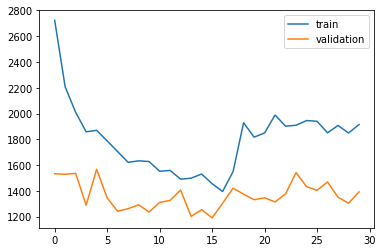

In [22]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend();

In [ ]:
# all data predict plot
y_pred = model.predict(X_test)
plt.plot(y_test.flatten(),marker='.',label='true')
plt.plot(y_pred.flatten(),'r',marker='.',label='predicted')
plt.legend();

In [ ]:
# 擷取部分資料繪圖
a=y_pred[:721]
b=y_test[:721]
y_pred = model.predict(X_test)
plt.plot(b.flatten(),marker='.',label='true')
plt.plot(a.flatten(),'r',marker='.',label='predicted')
plt.legend();